# Preprocessing of individual surveys
## Introduction

Included here:
* [Eurobarometer 34.0 (Oct-Nov 1990)](https://www.gesis.org/en/eurobarometer-data-service/survey-series/standard-special-eb/study-overview/eurobarometer-340-za-1960-oct-nov-1990)
* [Eurobarometer 41.0 (Mar-May 1994)](https://www.gesis.org/en/eurobarometer-data-service/survey-series/standard-special-eb/study-overview/eurobarometer-410-za-2490-mar-may-1994)
* [Eurobarometer 44.0 (Oct-Nov 1995)](https://www.gesis.org/en/eurobarometer-data-service/survey-series/standard-special-eb/study-overview/eurobarometer-440-za-2689-oct-nov-1995)
* [Eurobarometer 50.0 (Oct-Nov 1998)](https://www.gesis.org/en/eurobarometer-data-service/survey-series/standard-special-eb/study-overview/eurobarometer-500-za-3085-oct-nov-1998)
* [Eurobarometer 52.0 (Oct-Nov 1999)](https://www.gesis.org/en/eurobarometer-data-service/survey-series/standard-special-eb/study-overview/eurobarometer-520-za-3204-oct-nov-1999)
* [Eurobarometer 54LAN  (Dec 2000)](https://www.gesis.org/en/eurobarometer-data-service/survey-series/standard-special-eb/study-overview/eurobarometer-54lan-za-3389-dec-2000)
* [Eurobarometer 55.1  (April-May 2001)](https://www.gesis.org/en/eurobarometer-data-service/survey-series/standard-special-eb/study-overview/eurobarometer-551-za-3507-apr-may-2001)
* [Eurobarometer 63.4 (May-Jun 2005)](https://search.gesis.org/research_data/ZA4411)
* [Eurobarometer 64.3 (Nov- Dec 2005)](https://www.gesis.org/en/eurobarometer-data-service/survey-series/standard-special-eb/study-overview/eurobarometer-643-za-4415-nov-dec-2005)
* [Eurobarometer 77.1 (2012)](https://dbk.gesis.org/dbksearch/SDesc2.asp?ll=10&notabs=1&af=&nf=&search=&search2=&db=E&no=5597) 

Not included: 
* [Eurobarometer 28 (Oct-Nov 1987)](https://www.gesis.org/en/eurobarometer-data-service/survey-series/standard-special-eb/study-overview/eurobarometer-28-za-1713-oct-nov-1987) -> mother tongue not polled
* [Eurobarometer 28.1 (Oct-Nov 1987)](https://www.gesis.org/en/eurobarometer-data-service/survey-series/standard-special-eb/study-overview/eurobarometer-281-za-2041-oct-nov-1987) -> only respondents aged 15-24
* [Eurobarometer 47.2OVR (Apr-June 1997)](https://www.gesis.org/en/eurobarometer-data-service/survey-series/standard-special-eb/study-overview/eurobarometer-472ovr-za-2938-apr-jun-1997) -> doesn't ask about mother tongue, youth oversample
* [Candidate Countries EB 2003.1YouthOVR (March-May 2003)](https://www.gesis.org/en/eurobarometer-data-service/survey-series/candidate-countries-eb/study-profiles/cc-eb-20031youth) -> youth oversample

TODO?
* [Candidate Countries EB 2001.1 (October 2001)](https://www.gesis.org/en/eurobarometer-data-service/survey-series/candidate-countries-eb/study-profiles/cc-eb-20011)
* [Candidate Countries EB 2002.2 (Sep-Oct 2002)](https://www.gesis.org/en/eurobarometer-data-service/survey-series/candidate-countries-eb/study-profiles/cc-eb-20022)

### Selected questions for L1 and L2
All selected surveys contain the following data:
* Origin country of sample.
* L1 data. Languages provided as answers to the following questions:
    1. What is you mother tongue? (LM)
    2. What language do you speak at home? (LH) (only somewhat reflects mother tongue)
* L2 data. Languages provided as answers to the following questions:
    1. What is your second/third/fourth/etc. language? Which languages have you learned, except your mothertongue? (LL)
    3. Which languages do you speak well enough to hold a conversation, except your mothertongue? (LS)
    
Answers could be provided both in single and multiple choice.

### Encoding
* Multiple choice, `n` options: `n` consecutive columns (mostly) with key `v{question number i}` corresponding to one language each, e.g. `v123` might indicate the answers for French. Answers are indicated (mostly) with `(not) mentioned`. Order and possible selection of languages vary between surveys and must be provided separately (see below).
* Single: Single column with key `v{question number}` Language as string or missing. `DK` if the question could not be answered.


### Reproducability / Input
* `data/raw_data`:
    * Survey microdata (see links) in `.sav` format . Prefix filenames with `EB{ survey number }_`.
    * Newline separated language choices `langs_{survey number}.txt`used for multiple choice questions.

## Setup

In [1]:
%%html
<style>
    table {float:left}
</style>

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

_ = !pip install pyreadstat

In [3]:
basedir = '../../data/eurobarometer/'
in_dir = basedir + "raw_data/"

step1_dir = basedir + "step1/"
os.makedirs(step1_dir, exist_ok=True)

## Util

In [4]:
def open_survey(survey):
    """
    Load SPSS dataframe
    """
    path = f'{in_dir}{survey}.sav'
    df = pd.read_spss(path)
    return df

def get_langs(filename):
    """
    Load list of languages used for multiple choice questions
    """
    with open(f'{in_dir}{filename}') as fp:
        ls = [l.title() for l in fp.read().split('\n')]
        print(" ".join(ls))
        return ls

def plot_valuecounts(L1, L2, idx):
    """
    Plot barplots - how many respondents gave 1, 2, etc. languages as their first/second languages
    
    L1 - Dataframe indicating whether a language was mentioned as L1 or not, using 0 and 1
    L2 - Dataframe indicating whether a language was mentioned as L2 or not, using 0 and 1
    idx - Rows of L1 to include
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,3))
    l1c = L1.loc[idx].sum(axis=1).value_counts()
    l2c = L2.sum(axis=1).value_counts()
    ax1.bar(l1c.index, l1c.values)
    ax2.bar(l2c.index, l2c.values)
    
def delete_duplicates_from_L2(L1, L2):
    """
    Set languages to 0 for L2 if they were mentioned as L1, as the respondent's mother tongue should not be counted as foreign language.
    
    L1 - Dataframe indicating whether a language was mentioned as L1 or not, using 0 and 1
    L2 - Dataframe indicating whether a language was mentioned as L2 or not, using 0 and 1
    """
    l_intersec = set([ c.split('_')[1] for c in L1.columns]).intersection([ c.split('_')[1] for c in L2.columns])
    for l in l_intersec:
        if l == 'Other':
            continue
        and_idx = L2['L2_' + l] * L1['L1_' + l]
        and_idx = and_idx.astype(bool)
        if and_idx.sum() > 0:
            print(l, 'mentioned both for L1 and L2:', and_idx.sum())
        L2.loc[and_idx, 'L2_' + l] = 0
    return L2

def concat_and_save(nat, L1, L2, year, survey, idx=None):
    """
    Concat arguments into one dataframe containing nationality, indicated L1 and L2, and year of the survey and save it in csv format. 
    Only consider the rows/respondents indicated by idx. Plot distribution of number of L1/L2 given.
    
    nat - Series indicating nationality of respondents
    L1 - Dataframe indicating whether a language was mentioned as L1 or not, using 0 and 1
    L2 - Dataframe indicating whether a language was mentioned as L2 or not, using 0 and 1
    year - Year the survey was held in
    idx - Rows of L1 to include
    """
    L2 = delete_duplicates_from_L2(L1, L2)
    res = pd.concat([nat, L1, L2], axis=1)
    lcols = list(L1.columns) + list(L2.columns)
    res.loc[:, lcols] = res.loc[:, lcols].clip(0, 1)
    res = res.drop('L2_nan', axis=1, errors='ignore') # 
    res['Year'] = year
    
    if idx is not None:
        res = res.loc[idx, :].reset_index(drop=True)
        
    res.to_csv(f'{step1_dir}{survey}.csv', index=False)
    plot_valuecounts(L1, L2, idx)    
    return res

In [5]:
def rename(df, frm, to, ls, new_prefix, old_prefix='v'):
    """
    Clean up question data provided in multiple choice format/wide form, i.e. `n` columns named `{old prefix}{i}` with `i` in `[frm, to]`. 
    Map values to 1 and 0 indicating mentioned or not mentioned respectively. 
    Rename columns to be easily readable and mergeable, e.g. `{new prefix}_{language name}`. 
    The language name is decoded from the column index according to the list of choices of languages (`ls`). 
    
    [frm, to] - range of column numbers belonging to the question
    ls - list of languages corresponding to the columns indicated by frm, to
    new_prefix - prefix for the new column names
    old_prefix - prefix for the column names
    """
    keys = [f'{old_prefix}{i}' for i in range(frm, to + 1)]
    if len(keys) != len(ls):
        print('Warning: Languages might not match columns')
    d = df[keys].astype(object)\
        .fillna(0)\
        .apply(lambda x: x.str.lower())\
        .replace('mentioned', 1)\
        .replace({'not mentioned': 0})\
        .fillna(0)\
        .astype(int)
    new_keys = [f'{new_prefix}_{l}' for l in ls]
    d = d.rename(dict(zip(keys, new_keys)), axis=1)
    d = d.drop([f'{new_prefix}_Dk', f'{new_prefix}_None'], axis=1, errors='ignore')
    return d

In [6]:
def piv(df, nq, new_prefix="L2", old_prefix="v", ls=None):
    """
    Pivot answers to single choice questions from one column containing the language string to `n` columns with 0/1 encoding 
    (for compatibility with multiple choice questions). 
    
    nq - column number for the question
    new_prefix - prefix for the new column names
    old_prefix - prefix for the column names
    ls - List of languages which should appear as columns. Will be inferred from column values if not given.
    """
    key = f'{old_prefix}{nq}'
    df[key] = df[key].str.title()
    dk = df[key].fillna('None').astype(str).to_frame().replace(['No Second Language', 'No Third Language', 'Dk'], 'None')
    d = new_prefix + '_' + dk
    d['cnt'] = 1
    d = d.pivot(columns=key).fillna(0).astype(int)
    d.columns = d.columns.droplevel()
    
    if ls:
        cols = set([c.split('_')[1] for c in d.columns])
        diff = set(ls) - set(cols)
        d[[f'{new_prefix}_{l}' for l in diff]] = 0
        
    d = d.drop([f'{new_prefix}_Dk', f'{new_prefix}_None'], axis=1, errors='ignore')
    return d


## Clean up dfs

* LM - What is you mother tongue?
* LH - What language do you speak at home?
* LL - What is your second/third/fourth/etc. language? Which languages have you learned, except your mothertongue?
* LS - Which languages do you speak well enough to hold a conversation, except your mothertongue?

### EB 77.1
| Proficiency | Question Type | Columns |
| --- | --- | --- |
| L1 | LM | d48a_1 - d48a_39 |
| L1 | LH | - |
| L2 | LL | d48b, d48c, d48d |
| L2 | LS | - |

In [7]:
survey = 'EB771_2012_ZA5597_v3-0-0'
year = 2012
df = open_survey(survey)

Arabic Basque Bulgarian Catalan Chinese Croatian Czech Danish Dutch English Estonian Finnish French Galician German Greek Hindi Hungarian Irish / Gaelic Italian Japanese Korean Latvian Lithuanian Luxembourgish Maltese Polish Portuguese Romanian Russian Scottish Gaelic Slovak Slovenian Spanish Swedish Turkish Urdu Welsh Other None
Danish mentioned both for L1 and L2: 1
Italian mentioned both for L1 and L2: 1
German mentioned both for L1 and L2: 1


,L1_Arabic,L1_Basque,L1_Bulgarian,L1_Catalan,L1_Chinese,L1_Croatian,L1_Czech,L1_Danish,L1_Dutch,L1_English,...,L2_Russian,L2_Scottish Gaelic,L2_Slovak,L2_Slovenian,L2_Spanish,L2_Swedish,L2_Turkish,L2_Urdu,L2_Welsh,Year
isocntry,,,,,,,,,,,,,,,,,,,,,
AT,2,0,3,3,1,21,1,1,3,2,...,18,0,2,9,47,4,3,0,0,2074372
BE,31,0,2,0,2,2,0,4,585,5,...,6,0,1,0,51,1,4,0,0,2114612
BG,0,0,956,0,0,1,0,0,0,2,...,261,0,0,0,20,0,21,0,0,2024072
CY,4,0,2,0,0,0,0,0,0,5,...,19,0,1,0,8,2,15,0,0,1018072
CZ,0,0,0,0,0,0,977,0,0,7,...,132,0,163,0,7,0,0,0,0,2018036


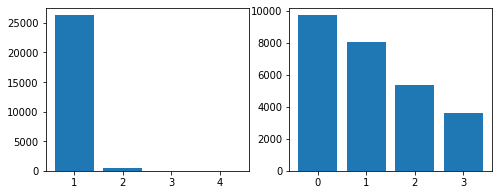

In [8]:
ls = get_langs('languages_771.txt')
         
L1 = rename(df, 1, 39, ls, "L1", old_prefix='d48a_')
rows = L1[L1.sum(axis=1) > 0].index

# Multiple questions for L2 - What is your first, second etc. language?
cols = [f"L2_{l}" for l in ls if l != 'None']
L2 = pd.DataFrame(index=L1.index, columns=cols).fillna(0)
for nq in ['b', 'c', 'd']:
    d = piv(df, nq, old_prefix='d48', ls=ls)
    L2 = L2 + d

nat = df['isocntry']
res = concat_and_save(nat, L1, L2, year, survey, idx=rows)  
res.groupby('isocntry').sum().head()

### EB 64.3
| Proficiency | Question Type | Columns |
| --- | --- | --- |
| L1 | LM | v264 - v303 |
| L1 | LH | - |
| L2 | LL | - |
| L2 | LS | v304, v305, v306 |

In [9]:
survey = 'EB643_2005_ZA4415_v1-0-1'
year = 2005
df = open_survey(survey)

German English Arabic Bulgarian Catalan Chinese Croatian Danish Spanish Estonian Finnish French Greek Hungarian Italian Latvian Lithuanian Luxembourgish Maltese Dutch Polish Portuguese Romanian Russian Slovak Slovenian Swedish Czech Turkish Irish / Gaelic Basque Galician Other Regional Hindi Urdu Punjabi Gujarati Bengali Other Dk
Other Regional mentioned both for L1 and L2: 4


,L1_German,L1_English,L1_Arabic,L1_Bulgarian,L1_Catalan,L1_Chinese,L1_Croatian,L1_Danish,L1_Spanish,L1_Estonian,...,L2_Punjabi,L2_Romanian,L2_Russian,L2_Slovak,L2_Slovenian,L2_Spanish,L2_Swedish,L2_Turkish,L2_Urdu,Year
isocntry,,,,,,,,,,,,,,,,,,,,,
AT,959,3,4,0,1,1,9,0,0,0,...,0,1,16,0,13,37,2,3,0,2009010
BE,4,3,13,0,0,0,0,0,5,0,...,0,2,2,0,0,54,0,0,0,2005000
BG,1,1,0,902,0,0,0,0,0,0,...,0,8,350,0,0,18,1,25,0,2013020
CY,0,5,0,0,0,0,0,0,0,0,...,0,3,10,0,0,7,2,8,0,1006510
CZ,3,1,0,2,0,0,1,0,0,0,...,0,1,221,163,2,2,1,0,0,2063145


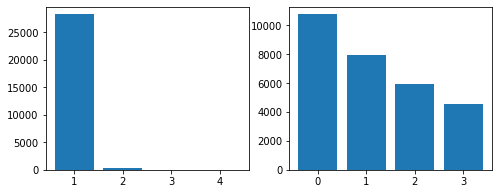

In [10]:
ls = get_langs('languages_643.txt')
df = df.replace('Irish/Gael', 'Irish / Gaelic')
L1 = rename(df, 264, 303, ls, "L1")
rows = L1[L1.sum(axis=1) > 0].index

cols = [f"L2_{l}" for l in ls if l != 'None']
L2 = pd.DataFrame(index=L1.index, columns=cols).fillna(0)
for nq in range(304, 307):
    d = piv(df, nq, ls=ls)
    L2 = L2 + d

nat = df['v7'].rename('isocntry', axis=1)
res = concat_and_save(nat, L1, L2, year, survey, idx=rows)  
res.groupby('isocntry').sum().head()

### EB 63.4
| Proficiency | Question Type | Columns |
| --- | --- | --- |
| L1 | LM | v442 - v476|
| L1 | LH | - |
| L2 | LL | - |
| L2 | LS | v477, v478, v479, v480-v514 |

In [11]:
survey = 'EB634_2005_ZA4411_v1-1-0'
year = 2005
df = open_survey(survey)

German English Arabic Bulgarian Catalan Chinese Croatian Danish Spanish Estonian Finnish French Greek Hungarian Italian Latvian Lithuanian Luxembourgish Maltese Dutch Norwegian Polish Portuguese Romanian Russian Slovak Slovenian Swedish Czech Turkish Irish / Gaelic Basque Sign Language Other Dk


,L1_German,L1_English,L1_Arabic,L1_Bulgarian,L1_Catalan,L1_Chinese,L1_Croatian,L1_Danish,L1_Spanish,L1_Estonian,...,L2_Portuguese,L2_Romanian,L2_Russian,L2_Sign Language,L2_Slovak,L2_Slovenian,L2_Spanish,L2_Swedish,L2_Turkish,Year
isocntry,,,,,,,,,,,,,,,,,,,,,
AT,966,10,0,2,0,0,7,0,0,0,...,1,4,12,18,4,14,32,3,2,2002995
BE,2,1,15,1,0,2,1,0,2,0,...,7,1,4,2,0,0,39,0,1,2005000
BG,0,1,1,893,0,0,0,0,0,1,...,2,13,211,0,0,0,10,0,29,2031065
CY,2,3,1,0,0,0,0,0,0,0,...,0,2,5,0,0,0,8,0,6,1012525
CY-TCC,0,8,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,2,0,1,1002500


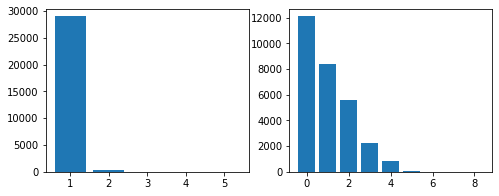

In [12]:
ls = get_langs('languages_634.txt')

L1 = rename(df, 442, 476, ls, "L1")
rows = L1[L1.sum(axis=1) > 0].index

L2 = rename(df, 480, 514, ls, "L2")
for nq in range(477, 480):
    d = piv(df, nq, ls=ls)
    L2 = L2 + d
    
nat = df['v7'].rename('isocntry', axis=1)
res = concat_and_save(nat, L1, L2, year, survey, idx=rows)
res.groupby('isocntry').sum().head()

### EB 55.1
| Proficiency | Question Type | Columns |
| --- | --- | --- |
| L1 | LM | v38 |
| L1 | LH | - |
| L2 | LL | - |
| L2 | LS | v39 - v53 |

Danish German French Italian Dutch English Spanish Portuguese Greek Swedish Finnish Arabic Chinese Other Dk
Finnish mentioned both for L1 and L2: 1


,L1_Arabic,L1_Chinese,L1_Danish,L1_Dutch,L1_English,L1_Finnish,L1_French,L1_German,L1_Greek,L1_Italian,...,L2_English,L2_Spanish,L2_Portuguese,L2_Greek,L2_Swedish,L2_Finnish,L2_Arabic,L2_Chinese,L2_Other,Year
isocntry,,,,,,,,,,,,,,,,,,,,,
AT,1,0,2,1,3,0,3,998,1,0,...,595,27,8,7,2,1,1,1,26,2071035
BE,4,0,0,539,5,0,433,7,2,24,...,399,42,3,2,1,1,4,0,25,2095047
DE-E,0,0,6,0,1,0,1,1040,1,2,...,313,6,2,1,1,0,1,0,123,2103051
DE-W,0,0,9,1,2,0,3,992,0,22,...,496,32,3,5,1,1,1,0,62,2071035
DK,1,0,981,0,3,0,0,4,0,0,...,765,28,3,1,85,2,0,1,38,2005002


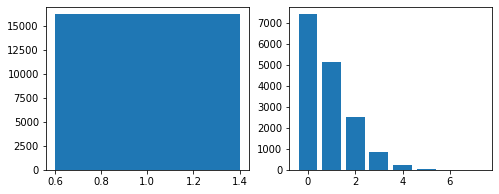

In [13]:
survey = 'EB551_2001_ZA3507_v1-0-1'
year = 2001
df = open_survey(survey)
ls = get_langs('languages_551.txt')

L2 = rename(df, 39, 53, ls, 'L2')
L1 = piv(df, 38, "L1", ls=ls)
rows = L1[L1.sum(axis=1) > 0].index

nat = df['isocntry']
res = concat_and_save(nat, L1, L2, year, survey, idx=rows)  
res.groupby('isocntry').sum().head()

#### EB 54LAN

LL here: What is your first, second, third, fourth foreign language?

| Proficiency | Question Type | Columns |
| --- | --- | --- |
| L1 | LM | v24 - v42 |
| L1 | LH | - |
| L2 | LL | v43 - v62, v63 - v82, v83 - v102, v103 - v122 |
| L2 | LS | - |

Danish German French Italian Dutch English Spanish Portuguese Greek Irish Swedish Finnish Luxembourgish Arabic Turkish Chinese Sign Language Other None Dk


,L1_Danish,L1_German,L1_French,L1_Italian,L1_Dutch,L1_English,L1_Spanish,L1_Portuguese,L1_Greek,L1_Irish,...,L2_Irish,L2_Swedish,L2_Finnish,L2_Luxembourgish,L2_Arabic,L2_Turkish,L2_Chinese,L2_Sign Language,L2_Other,Year
isocntry,,,,,,,,,,,,,,,,,,,,,
AT,6,933,7,2,0,13,0,0,5,0,...,0,5,0,0,2,4,1,1,32,1960000
BE,0,14,375,34,532,7,4,2,0,0,...,1,0,0,5,7,1,0,1,13,1960000
DE-E,4,1009,1,2,1,11,2,0,1,0,...,1,2,0,0,0,3,0,0,221,2062000
DE-W,4,953,6,2,1,20,1,0,2,0,...,0,3,1,3,2,2,0,1,62,2000000
DK,968,6,2,1,1,3,3,0,0,1,...,0,32,25,0,2,0,0,0,4,1994000


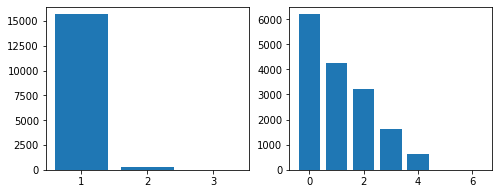

In [14]:
survey = 'EB54LAN_2000_ZA3389_v1-0-1'
year = 2000
df = open_survey(survey)
ls = get_langs('languages_54LAN.txt')

L1 = rename(df, 24, 42, ls, 'L1')
rows = L1[L1.sum(axis=1) > 0].index
L2 = rename(df, 43, 62, ls, 'L2')
for frm, to in [(63, 82),(83, 102), (103, 122)]:
    L2 = L2 + rename(df, frm, to, ls, 'L2')

nat = df['isocntry']
res = concat_and_save(nat, L1, L2, year, survey, idx=rows)  
res.groupby('isocntry').sum().head()

### EB 52.0 

| Proficiency | Question Type | Columns |
| --- | --- | --- |
| L1 | LM | v38 |
| L1 | LH | - |
| L2 | LL | - |
| L2 | LS | v49 - v63 |

Danish German French Italian Dutch English Spanish Portuguese Greek Swedish Finnish Arabic Chinese Other Dk


,L1_Arabic,L1_Chinese,L1_Danish,L1_Dutch,L1_English,L1_Finnish,L1_French,L1_German,L1_Greek,L1_Italian,L1_Other,L1_Portuguese,L1_Spanish,L1_Swedish,L2_Danish,L2_German,L2_French,L2_Italian,L2_Dutch,Year
isocntry,,,,,,,,,,,,,,,,,,,,
AT,1,1,5,2,5,0,0,985,1,0,17,0,1,0,0,22,87,76,8,2034982
BE,1,0,3,551,5,0,423,4,3,34,4,2,5,0,1,146,360,27,143,2068965
DE-E,0,0,2,0,1,0,1,1007,0,0,8,0,0,0,0,8,36,0,1,2036981
DE-W,0,0,2,0,3,0,4,984,4,3,12,0,5,1,4,30,107,16,19,2034982
DK,0,0,973,1,12,1,1,2,0,0,5,1,1,2,16,496,76,12,8,1997001


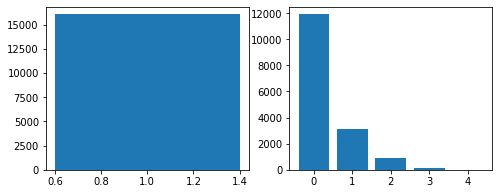

In [15]:
survey = 'EB520_1999_ZA3204_v1-0-1'
year = 1999
df = open_survey(survey)
df = df.replace('Other (SPECIFY)', 'Other')
ls = get_langs('languages_520.txt')

L1 = piv(df, 38, "L1", ls=ls)
rows = L1[L1.sum(axis=1) > 0].index
L2 = rename(df, 49, 53, ls, 'L2')

nat = df['isocntry']
res = concat_and_save(nat, L1, L2, year, survey, idx=rows)  
res.groupby('isocntry').sum().head()

### EB 50.0

| Proficiency | Question Type | Columns |
| --- | --- | --- |
| L1 | LM | v38 |
| L1 | LH | - |
| L2 | LL | - |
| L2 | LS | v39 - v55 |

Danish German French Italian Dutch English Spanish Portuguese Greek Swedish Finnish Russian Arabic Chinese Japanese Other Dk


,L1_Arabic,L1_Chinese,L1_Danish,L1_Dutch,L1_English,L1_Finnish,L1_French,L1_German,L1_Greek,L1_Italian,...,L2_Portuguese,L2_Greek,L2_Swedish,L2_Finnish,L2_Russian,L2_Arabic,L2_Chinese,L2_Japanese,L2_Other,Year
isocntry,,,,,,,,,,,,,,,,,,,,,
AT,1,1,1,0,8,0,2,989,2,3,...,2,4,1,1,10,1,1,0,40,2083914
BE,0,0,1,552,4,0,406,9,1,26,...,4,2,1,0,1,2,1,0,9,2023974
DE-E,0,0,0,0,0,0,0,1004,1,0,...,1,0,0,0,128,0,0,0,16,2019978
DE-W,1,0,0,1,3,0,1,980,6,6,...,1,1,0,0,18,0,0,0,21,2025972
DK,0,0,985,1,3,0,0,3,0,1,...,1,2,88,2,7,0,1,0,31,2003994


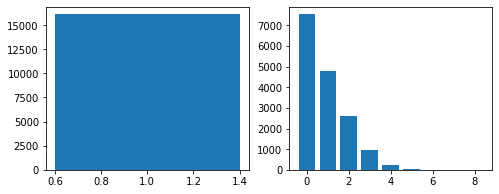

In [16]:
survey = 'EB500_1998_ZA3085_v1-1-0'
year = 1998
df = open_survey(survey)
ls = get_langs('languages_500.txt')

L2 = rename(df, 39, 55, ls, 'L2')
L1 = piv(df, 38, 'L1', ls=ls)
rows = L1[L1.sum(axis=1) > 0].index

nat = df['isocntry']
res = concat_and_save(nat, L1, L2, year, survey, idx=rows)  
res.groupby('isocntry').sum().head()

### EB 44.0

| Proficiency | Question Type | Columns |
| --- | --- | --- |
| L1 | LM | v264 - v280 |
| L1 | LH | - |
| L2 | LL | - |
| L2 | LS | v281 - v297 |

Danish German French Italian Dutch English Spanish Portuguese Greek Swedish Finnish Russian Arabic Chinese Japanese Other Dk
French mentioned both for L1 and L2: 44


,L1_Danish,L1_German,L1_French,L1_Italian,L1_Dutch,L1_English,L1_Spanish,L1_Portuguese,L1_Greek,L1_Swedish,...,L2_Portuguese,L2_Greek,L2_Swedish,L2_Finnish,L2_Russian,L2_Arabic,L2_Chinese,L2_Japanese,L2_Other,Year
isocntry,,,,,,,,,,,,,,,,,,,,,
AT,5,980,3,1,0,1,0,0,1,0,...,6,6,2,2,6,3,0,1,30,2000985
BE,1,6,394,27,546,4,9,1,1,0,...,4,3,0,2,2,6,1,2,20,1995000
DE-E,3,1081,5,0,0,1,1,0,0,0,...,1,1,0,0,178,0,0,1,19,2182530
DE-W,3,1068,11,5,2,2,4,1,5,3,...,2,5,2,1,17,2,1,0,20,2222430
DK,982,2,0,0,1,3,2,0,1,1,...,3,3,212,3,5,5,1,0,36,1983030


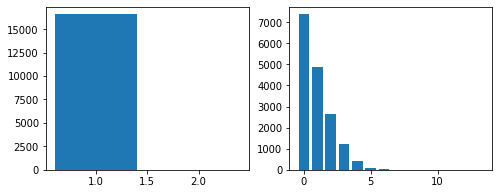

In [17]:
survey = 'EB440_1995_ZA2689_v1-0-1'
year = 1995
df = open_survey(survey)
ls = get_langs('languages_440.txt')

L1 = rename(df, 264, 280, ls, 'L1')
rows = L1[L1.sum(axis=1) > 0].index
L2 = rename(df, 281, 297, ls, 'L2')

nat = df['isocntry']
res = concat_and_save(nat, L1, L2, year, survey, idx=rows)  
res.groupby('isocntry').sum().head()

### EB 41.0

| Proficiency | Question Type | Columns |
| --- | --- | --- |
| L1 | LM | v209 |
| L1 | LH | (v234 - v245) |
| L2 | LL | v210 - v221 |
| L2 | LS | v222 - v233 |

In [18]:
survey = 'EB410_1994_ZA2490_v1-1-0'
year = 1994
df = open_survey(survey)
ls = get_langs('languages_410.txt')

Danish German French Italian Dutch English Spanish Portuguese Greek Other None Dk


,L1_Danish,L1_Dutch,L1_English,L1_French,L1_German,L1_Greek,L1_Italian,L1_Other,L1_Portuguese,L1_Spanish,...,L2_German,L2_French,L2_Italian,L2_Dutch,L2_English,L2_Spanish,L2_Portuguese,L2_Greek,L2_Other,Year
isocntry,,,,,,,,,,,,,,,,,,,,,
BE,0,616,0,417,8,6,0,15,25,0,...,291,503,62,236,532,74,3,13,36,2167478
DE-E,6,0,0,0,1044,0,0,8,0,0,...,10,52,8,0,359,9,2,2,435,2109652
DE-W,10,0,6,4,991,9,9,24,2,9,...,68,256,35,14,619,36,6,8,78,2121616
DK,991,0,1,0,4,0,1,8,0,0,...,754,295,24,17,826,63,4,7,104,2003970
ES,0,0,1,1,0,0,2,138,0,861,...,25,183,21,4,258,129,17,6,127,1999982


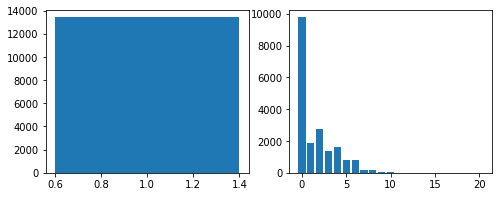

In [19]:
L1 = piv(df, 209, 'L1', ls=ls)
rows = L1[L1.sum(axis=1) > 0].index

L2 = rename(df, 210, 221, ls, 'L2')
L2 = L2 + rename(df, 222, 233, ls, 'L2')

nat = df['isocntry']
res = concat_and_save(nat, L1, L2, year, survey, idx=rows)  
res.groupby('isocntry').sum().head()

### EB 34.0

| Proficiency | Question Type | Columns |
| --- | --- | --- |
| L1 | LM | v181 - Country specific, data not available |
| L1 | LH | v206 - v217 |
| L2 | LL | v182 - v193 |
| L2 | LS | v194 - v205 |

Danish German French Italian Dutch English Spanish Portuguese Greek Other None Dk
Danish mentioned both for L1 and L2: 16
Dutch mentioned both for L1 and L2: 54
French mentioned both for L1 and L2: 135
Spanish mentioned both for L1 and L2: 67
Italian mentioned both for L1 and L2: 37
Portuguese mentioned both for L1 and L2: 6
German mentioned both for L1 and L2: 73
English mentioned both for L1 and L2: 163
Greek mentioned both for L1 and L2: 6


,L1_Danish,L1_German,L1_French,L1_Italian,L1_Dutch,L1_English,L1_Spanish,L1_Portuguese,L1_Greek,L1_Other,...,L2_German,L2_French,L2_Italian,L2_Dutch,L2_English,L2_Spanish,L2_Portuguese,L2_Greek,L2_Other,Year
isocntry,,,,,,,,,,,,,,,,,,,,,
BE,0,2,435,2,565,13,1,0,0,9,...,322,400,41,223,498,59,5,14,32,1980050
DE-E,3,1021,2,0,0,6,0,0,0,14,...,0,45,4,2,367,3,0,1,418,2031790
DE-W,12,1002,3,3,0,14,4,1,2,8,...,0,222,32,10,554,40,2,10,64,1993980
DK,992,11,3,1,1,22,0,0,1,5,...,760,301,33,10,813,63,5,8,43,1990000
ES,0,1,2,0,0,7,850,3,0,164,...,21,189,17,0,254,129,8,4,77,1990000


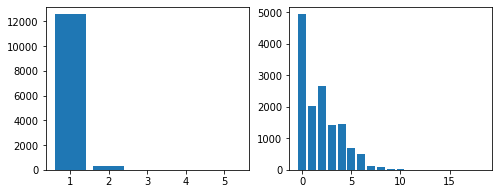

In [20]:
survey = 'EB340_1990_ZA1960_v1-0-1'
year = 1990
df = open_survey(survey)
ls = get_langs('languages_340.txt')

L1 = rename(df, 206, 217, ls, 'L1')
rows = L1[L1.sum(axis=1) > 0].index
L2 = rename(df, 182, 193, ls, 'L2')
L2 = L2 + rename(df, 194, 205, ls, 'L2')

nat = df['isocntry']
res = concat_and_save(nat, L1, L2, year, survey, idx=rows)  
res.groupby('isocntry').sum().head()

#### EB 28

| Proficiency | Question Type | Columns |
| --- | --- | --- |
| L1 | LM | - |
| L1 | LH | v97 - v106 |
| L2 | LL | v77 - v86 |
| L2 | LS | v87 - v95 |

In [21]:
survey = 'EB28_1987_ZA1713_v1-1-0'
year = 1987
df = open_survey(survey)
ls = get_langs('languages_28.txt')

Danish German French Italian Dutch English Spanish Portuguese Greek Other


Danish mentioned both for L1 and L2: 767
Dutch mentioned both for L1 and L2: 1411
French mentioned both for L1 and L2: 1298
Spanish mentioned both for L1 and L2: 990
Italian mentioned both for L1 and L2: 1032
Portuguese mentioned both for L1 and L2: 1006
German mentioned both for L1 and L2: 921
English mentioned both for L1 and L2: 2191
Greek mentioned both for L1 and L2: 1002


,L1_Danish,L1_German,L1_French,L1_Italian,L1_Dutch,L1_English,L1_Spanish,L1_Portuguese,L1_Greek,L1_Other,...,L2_German,L2_French,L2_Italian,L2_Dutch,L2_English,L2_Spanish,L2_Portuguese,L2_Greek,L2_Other,Year
isocntry,,,,,,,,,,,,,,,,,,,,,
BE,0,6,430,5,558,3,1,0,0,2,...,120,260,28,129,294,37,5,1,14,1996935
DE,11,921,2,1,1,5,0,1,1,4,...,13,81,11,8,359,11,3,4,28,1855858
DK,946,8,1,1,2,16,0,0,0,3,...,332,48,1,7,512,4,3,3,25,1887650
ES,1,0,0,0,0,3,981,1,0,33,...,6,99,11,1,79,32,10,1,177,2016805
FR,0,11,973,6,0,9,9,2,0,16,...,56,14,44,1,218,76,4,0,35,1973091


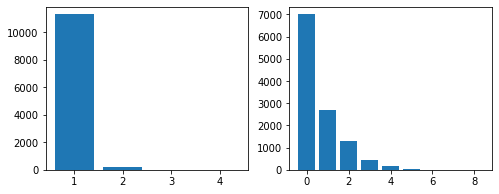

In [22]:
L1 = rename(df, 97, 106, ls, 'L1')
rows = L1[L1.sum(axis=1) > 0].index
L2 = rename(df, 77, 86, ls, 'L2')
L2 = L2 + rename(df, 87, 96, ls, 'L2')
L2 = rename(df, 87, 96, ls, 'L2')

nat = df['isocntry']
res = concat_and_save(nat, L1, L2, year, survey, idx=rows)  
res.groupby('isocntry').sum().head()